# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

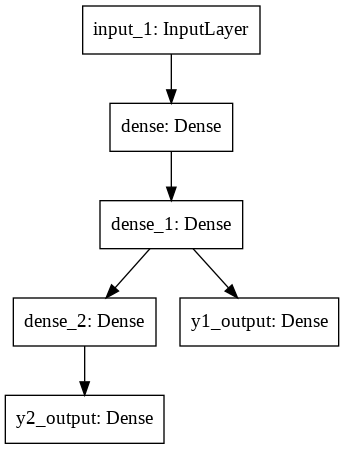

In [6]:
tf.keras.utils.plot_model(model)

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [7]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [8]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 251.0374 - y1_output_loss: 117.3704 - y2_output_loss: 131.5057 - y1_output_root_mean_squared_error: 10.8812 - y2_output_root_mean_squared_error: 11.5168 - val_loss: 60.8455 - val_y1_output_loss: 19.5976 - val_y2_output_loss: 49.6593 - val_y1_output_root_mean_squared_error: 4.2095 - val_y2_output_root_mean_squared_error: 6.5670
Epoch 2/500
614/614 [==============================] - 0s 157us/sample - loss: 30.8567 - y1_output_loss: 11.8012 - y2_output_loss: 19.8823 - y1_output_root_mean_squared_error: 3.3918 - y2_output_root_mean_squared_error: 4.3991 - val_loss: 183.4863 - val_y1_output_loss: 30.5770 - val_y2_output_loss: 155.6157 - val_y1_output_root_mean_squared_error: 5.5217 - val_y2_output_root_mean_squared_error: 12.3692
Epoch 3/500
614/614 [==============================] - 0s 140us/sample - loss: 32.9329 - y1_output_loss: 10.8330 - y2_output_loss: 21.8817 - y

614/614 [==============================] - 0s 137us/sample - loss: 18.7285 - y1_output_loss: 6.4404 - y2_output_loss: 12.2643 - y1_output_root_mean_squared_error: 2.5392 - y2_output_root_mean_squared_error: 3.5044 - val_loss: 14.1720 - val_y1_output_loss: 7.1770 - val_y2_output_loss: 8.2256 - val_y1_output_root_mean_squared_error: 2.6364 - val_y2_output_root_mean_squared_error: 2.6872
Epoch 22/500
614/614 [==============================] - 0s 133us/sample - loss: 15.6652 - y1_output_loss: 5.7519 - y2_output_loss: 9.8723 - y1_output_root_mean_squared_error: 2.4051 - y2_output_root_mean_squared_error: 3.1433 - val_loss: 21.1551 - val_y1_output_loss: 7.8062 - val_y2_output_loss: 13.0624 - val_y1_output_root_mean_squared_error: 2.8341 - val_y2_output_root_mean_squared_error: 3.6226
Epoch 23/500
614/614 [==============================] - 0s 129us/sample - loss: 15.6021 - y1_output_loss: 5.7508 - y2_output_loss: 9.7338 - y1_output_root_mean_squared_error: 2.4069 - y2_output_root_mean_squared

614/614 [==============================] - 0s 129us/sample - loss: 10.3351 - y1_output_loss: 3.4714 - y2_output_loss: 6.8906 - y1_output_root_mean_squared_error: 1.8685 - y2_output_root_mean_squared_error: 2.6161 - val_loss: 8.5507 - val_y1_output_loss: 3.3913 - val_y2_output_loss: 5.7397 - val_y1_output_root_mean_squared_error: 1.8545 - val_y2_output_root_mean_squared_error: 2.2608
Epoch 42/500
614/614 [==============================] - 0s 127us/sample - loss: 8.5641 - y1_output_loss: 2.7976 - y2_output_loss: 5.7072 - y1_output_root_mean_squared_error: 1.6789 - y2_output_root_mean_squared_error: 2.3970 - val_loss: 8.0160 - val_y1_output_loss: 3.2426 - val_y2_output_loss: 5.2462 - val_y1_output_root_mean_squared_error: 1.8207 - val_y2_output_root_mean_squared_error: 2.1682
Epoch 43/500
614/614 [==============================] - 0s 131us/sample - loss: 8.9112 - y1_output_loss: 3.0114 - y2_output_loss: 5.8303 - y1_output_root_mean_squared_error: 1.7420 - y2_output_root_mean_squared_error

Epoch 62/500
614/614 [==============================] - 0s 128us/sample - loss: 4.8171 - y1_output_loss: 1.4118 - y2_output_loss: 3.3812 - y1_output_root_mean_squared_error: 1.1886 - y2_output_root_mean_squared_error: 1.8451 - val_loss: 4.6151 - val_y1_output_loss: 1.5916 - val_y2_output_loss: 3.2902 - val_y1_output_root_mean_squared_error: 1.2670 - val_y2_output_root_mean_squared_error: 1.7349
Epoch 63/500
614/614 [==============================] - 0s 129us/sample - loss: 5.4040 - y1_output_loss: 1.5628 - y2_output_loss: 3.8136 - y1_output_root_mean_squared_error: 1.2539 - y2_output_root_mean_squared_error: 1.9575 - val_loss: 8.3548 - val_y1_output_loss: 2.9138 - val_y2_output_loss: 5.4085 - val_y1_output_root_mean_squared_error: 1.7012 - val_y2_output_root_mean_squared_error: 2.3368
Epoch 64/500
614/614 [==============================] - 0s 129us/sample - loss: 6.3843 - y1_output_loss: 1.9378 - y2_output_loss: 4.5052 - y1_output_root_mean_squared_error: 1.3837 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 129us/sample - loss: 4.4455 - y1_output_loss: 1.0035 - y2_output_loss: 3.4122 - y1_output_root_mean_squared_error: 1.0035 - y2_output_root_mean_squared_error: 1.8543 - val_loss: 5.3584 - val_y1_output_loss: 1.3714 - val_y2_output_loss: 4.3195 - val_y1_output_root_mean_squared_error: 1.1828 - val_y2_output_root_mean_squared_error: 1.9899
Epoch 84/500
614/614 [==============================] - 0s 132us/sample - loss: 3.6138 - y1_output_loss: 0.8993 - y2_output_loss: 2.7108 - y1_output_root_mean_squared_error: 0.9458 - y2_output_root_mean_squared_error: 1.6490 - val_loss: 5.1958 - val_y1_output_loss: 1.3377 - val_y2_output_loss: 4.2297 - val_y1_output_root_mean_squared_error: 1.1723 - val_y2_output_root_mean_squared_error: 1.9549
Epoch 85/500
614/614 [==============================] - 0s 136us/sample - loss: 3.8268 - y1_output_loss: 0.9822 - y2_output_loss: 2.8305 - y1_output_root_mean_squared_error: 0.9878 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 128us/sample - loss: 2.8695 - y1_output_loss: 0.7204 - y2_output_loss: 2.1325 - y1_output_root_mean_squared_error: 0.8499 - y2_output_root_mean_squared_error: 1.4653 - val_loss: 2.9433 - val_y1_output_loss: 0.7079 - val_y2_output_loss: 2.3708 - val_y1_output_root_mean_squared_error: 0.8541 - val_y2_output_root_mean_squared_error: 1.4879
Epoch 105/500
614/614 [==============================] - 0s 126us/sample - loss: 2.2339 - y1_output_loss: 0.4658 - y2_output_loss: 1.7632 - y1_output_root_mean_squared_error: 0.6812 - y2_output_root_mean_squared_error: 1.3303 - val_loss: 3.4772 - val_y1_output_loss: 0.8474 - val_y2_output_loss: 2.7832 - val_y1_output_root_mean_squared_error: 0.9335 - val_y2_output_root_mean_squared_error: 1.6142
Epoch 106/500
614/614 [==============================] - 0s 127us/sample - loss: 2.2364 - y1_output_loss: 0.5161 - y2_output_loss: 1.7191 - y1_output_root_mean_squared_error: 0.7152 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 2.1100 - y1_output_loss: 0.5149 - y2_output_loss: 1.6253 - y1_output_root_mean_squared_error: 0.7050 - y2_output_root_mean_squared_error: 1.2701 - val_loss: 3.9113 - val_y1_output_loss: 1.2543 - val_y2_output_loss: 2.6627 - val_y1_output_root_mean_squared_error: 1.1267 - val_y2_output_root_mean_squared_error: 1.6254
Epoch 125/500
614/614 [==============================] - 0s 128us/sample - loss: 2.1808 - y1_output_loss: 0.4560 - y2_output_loss: 1.7181 - y1_output_root_mean_squared_error: 0.6769 - y2_output_root_mean_squared_error: 1.3125 - val_loss: 2.5135 - val_y1_output_loss: 0.5593 - val_y2_output_loss: 2.1067 - val_y1_output_root_mean_squared_error: 0.7535 - val_y2_output_root_mean_squared_error: 1.3949
Epoch 126/500
614/614 [==============================] - 0s 133us/sample - loss: 2.3894 - y1_output_loss: 0.5957 - y2_output_loss: 1.8058 - y1_output_root_mean_squared_error: 0.7707 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 130us/sample - loss: 1.7759 - y1_output_loss: 0.4329 - y2_output_loss: 1.3293 - y1_output_root_mean_squared_error: 0.6603 - y2_output_root_mean_squared_error: 1.1575 - val_loss: 2.4989 - val_y1_output_loss: 0.5074 - val_y2_output_loss: 2.2065 - val_y1_output_root_mean_squared_error: 0.7214 - val_y2_output_root_mean_squared_error: 1.4066
Epoch 146/500
614/614 [==============================] - 0s 128us/sample - loss: 1.8080 - y1_output_loss: 0.4387 - y2_output_loss: 1.3819 - y1_output_root_mean_squared_error: 0.6625 - y2_output_root_mean_squared_error: 1.1701 - val_loss: 4.7369 - val_y1_output_loss: 1.1026 - val_y2_output_loss: 4.0856 - val_y1_output_root_mean_squared_error: 1.0374 - val_y2_output_root_mean_squared_error: 1.9133
Epoch 147/500
614/614 [==============================] - 0s 139us/sample - loss: 1.8515 - y1_output_loss: 0.3869 - y2_output_loss: 1.4812 - y1_output_root_mean_squared_error: 0.6203 - y2_output_root_mea

614/614 [==============================] - 0s 139us/sample - loss: 1.4825 - y1_output_loss: 0.3392 - y2_output_loss: 1.1587 - y1_output_root_mean_squared_error: 0.5803 - y2_output_root_mean_squared_error: 1.0704 - val_loss: 3.3607 - val_y1_output_loss: 0.6255 - val_y2_output_loss: 2.9760 - val_y1_output_root_mean_squared_error: 0.7920 - val_y2_output_root_mean_squared_error: 1.6533
Epoch 166/500
614/614 [==============================] - 0s 139us/sample - loss: 1.4812 - y1_output_loss: 0.3433 - y2_output_loss: 1.1302 - y1_output_root_mean_squared_error: 0.5860 - y2_output_root_mean_squared_error: 1.0667 - val_loss: 2.4574 - val_y1_output_loss: 0.4781 - val_y2_output_loss: 1.9928 - val_y1_output_root_mean_squared_error: 0.6828 - val_y2_output_root_mean_squared_error: 1.4111
Epoch 167/500
614/614 [==============================] - 0s 135us/sample - loss: 1.7292 - y1_output_loss: 0.3628 - y2_output_loss: 1.3662 - y1_output_root_mean_squared_error: 0.6027 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 129us/sample - loss: 1.4410 - y1_output_loss: 0.3208 - y2_output_loss: 1.1216 - y1_output_root_mean_squared_error: 0.5669 - y2_output_root_mean_squared_error: 1.0581 - val_loss: 3.0715 - val_y1_output_loss: 0.5317 - val_y2_output_loss: 2.5593 - val_y1_output_root_mean_squared_error: 0.7256 - val_y2_output_root_mean_squared_error: 1.5953
Epoch 187/500
614/614 [==============================] - 0s 132us/sample - loss: 1.1626 - y1_output_loss: 0.2391 - y2_output_loss: 0.9387 - y1_output_root_mean_squared_error: 0.4898 - y2_output_root_mean_squared_error: 0.9606 - val_loss: 4.8534 - val_y1_output_loss: 0.8748 - val_y2_output_loss: 3.9914 - val_y1_output_root_mean_squared_error: 0.9278 - val_y2_output_root_mean_squared_error: 1.9981
Epoch 188/500
614/614 [==============================] - 0s 127us/sample - loss: 1.2396 - y1_output_loss: 0.2668 - y2_output_loss: 0.9672 - y1_output_root_mean_squared_error: 0.5171 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.9356 - y1_output_loss: 0.2142 - y2_output_loss: 0.7178 - y1_output_root_mean_squared_error: 0.4642 - y2_output_root_mean_squared_error: 0.8486 - val_loss: 2.1340 - val_y1_output_loss: 0.4292 - val_y2_output_loss: 1.8890 - val_y1_output_root_mean_squared_error: 0.6508 - val_y2_output_root_mean_squared_error: 1.3078
Epoch 207/500
614/614 [==============================] - 0s 133us/sample - loss: 1.2327 - y1_output_loss: 0.2687 - y2_output_loss: 0.9580 - y1_output_root_mean_squared_error: 0.5195 - y2_output_root_mean_squared_error: 0.9812 - val_loss: 2.0006 - val_y1_output_loss: 0.3694 - val_y2_output_loss: 1.8433 - val_y1_output_root_mean_squared_error: 0.6142 - val_y2_output_root_mean_squared_error: 1.2741
Epoch 208/500
614/614 [==============================] - 0s 127us/sample - loss: 1.7202 - y1_output_loss: 0.4312 - y2_output_loss: 1.2828 - y1_output_root_mean_squared_error: 0.6571 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 128us/sample - loss: 1.3634 - y1_output_loss: 0.3231 - y2_output_loss: 1.0355 - y1_output_root_mean_squared_error: 0.5703 - y2_output_root_mean_squared_error: 1.0189 - val_loss: 1.9551 - val_y1_output_loss: 0.4281 - val_y2_output_loss: 1.6089 - val_y1_output_root_mean_squared_error: 0.6506 - val_y2_output_root_mean_squared_error: 1.2377
Epoch 228/500
614/614 [==============================] - 0s 127us/sample - loss: 1.0070 - y1_output_loss: 0.2320 - y2_output_loss: 0.7724 - y1_output_root_mean_squared_error: 0.4812 - y2_output_root_mean_squared_error: 0.8806 - val_loss: 2.1574 - val_y1_output_loss: 0.4650 - val_y2_output_loss: 1.8149 - val_y1_output_root_mean_squared_error: 0.6850 - val_y2_output_root_mean_squared_error: 1.2993
Epoch 229/500
614/614 [==============================] - 0s 128us/sample - loss: 0.9876 - y1_output_loss: 0.2208 - y2_output_loss: 0.7663 - y1_output_root_mean_squared_error: 0.4637 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 1.2110 - y1_output_loss: 0.2558 - y2_output_loss: 0.9602 - y1_output_root_mean_squared_error: 0.5078 - y2_output_root_mean_squared_error: 0.9763 - val_loss: 3.2070 - val_y1_output_loss: 0.3286 - val_y2_output_loss: 2.8607 - val_y1_output_root_mean_squared_error: 0.5684 - val_y2_output_root_mean_squared_error: 1.6982
Epoch 248/500
614/614 [==============================] - 0s 127us/sample - loss: 0.9688 - y1_output_loss: 0.2114 - y2_output_loss: 0.7519 - y1_output_root_mean_squared_error: 0.4592 - y2_output_root_mean_squared_error: 0.8706 - val_loss: 2.1023 - val_y1_output_loss: 0.5315 - val_y2_output_loss: 1.6453 - val_y1_output_root_mean_squared_error: 0.7134 - val_y2_output_root_mean_squared_error: 1.2622
Epoch 249/500
614/614 [==============================] - 0s 127us/sample - loss: 0.8387 - y1_output_loss: 0.2125 - y2_output_loss: 0.6386 - y1_output_root_mean_squared_error: 0.4599 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 126us/sample - loss: 0.7372 - y1_output_loss: 0.1566 - y2_output_loss: 0.5798 - y1_output_root_mean_squared_error: 0.3970 - y2_output_root_mean_squared_error: 0.7613 - val_loss: 1.8487 - val_y1_output_loss: 0.2955 - val_y2_output_loss: 1.7302 - val_y1_output_root_mean_squared_error: 0.5498 - val_y2_output_root_mean_squared_error: 1.2435
Epoch 269/500
614/614 [==============================] - 0s 126us/sample - loss: 0.7026 - y1_output_loss: 0.1703 - y2_output_loss: 0.5306 - y1_output_root_mean_squared_error: 0.4130 - y2_output_root_mean_squared_error: 0.7294 - val_loss: 1.4576 - val_y1_output_loss: 0.2871 - val_y2_output_loss: 1.2422 - val_y1_output_root_mean_squared_error: 0.5439 - val_y2_output_root_mean_squared_error: 1.0779
Epoch 270/500
614/614 [==============================] - 0s 126us/sample - loss: 1.1465 - y1_output_loss: 0.2267 - y2_output_loss: 0.9186 - y1_output_root_mean_squared_error: 0.4756 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.9749 - y1_output_loss: 0.2507 - y2_output_loss: 0.7256 - y1_output_root_mean_squared_error: 0.5023 - y2_output_root_mean_squared_error: 0.8501 - val_loss: 1.5142 - val_y1_output_loss: 0.2933 - val_y2_output_loss: 1.2494 - val_y1_output_root_mean_squared_error: 0.5433 - val_y2_output_root_mean_squared_error: 1.1041
Epoch 289/500
614/614 [==============================] - 0s 127us/sample - loss: 0.7949 - y1_output_loss: 0.1969 - y2_output_loss: 0.5922 - y1_output_root_mean_squared_error: 0.4451 - y2_output_root_mean_squared_error: 0.7725 - val_loss: 1.3470 - val_y1_output_loss: 0.2658 - val_y2_output_loss: 1.1615 - val_y1_output_root_mean_squared_error: 0.5187 - val_y2_output_root_mean_squared_error: 1.0382
Epoch 290/500
614/614 [==============================] - 0s 128us/sample - loss: 0.8206 - y1_output_loss: 0.2104 - y2_output_loss: 0.6078 - y1_output_root_mean_squared_error: 0.4566 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 135us/sample - loss: 0.9883 - y1_output_loss: 0.2355 - y2_output_loss: 0.7789 - y1_output_root_mean_squared_error: 0.4722 - y2_output_root_mean_squared_error: 0.8748 - val_loss: 4.9136 - val_y1_output_loss: 1.4652 - val_y2_output_loss: 3.5656 - val_y1_output_root_mean_squared_error: 1.2144 - val_y2_output_root_mean_squared_error: 1.8544
Epoch 310/500
614/614 [==============================] - 0s 133us/sample - loss: 0.8090 - y1_output_loss: 0.2111 - y2_output_loss: 0.5974 - y1_output_root_mean_squared_error: 0.4566 - y2_output_root_mean_squared_error: 0.7749 - val_loss: 1.9091 - val_y1_output_loss: 0.5766 - val_y2_output_loss: 1.3994 - val_y1_output_root_mean_squared_error: 0.7593 - val_y2_output_root_mean_squared_error: 1.1543
Epoch 311/500
614/614 [==============================] - 0s 126us/sample - loss: 0.6074 - y1_output_loss: 0.1523 - y2_output_loss: 0.4533 - y1_output_root_mean_squared_error: 0.3904 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 0.7392 - y1_output_loss: 0.1920 - y2_output_loss: 0.5594 - y1_output_root_mean_squared_error: 0.4239 - y2_output_root_mean_squared_error: 0.7480 - val_loss: 2.7622 - val_y1_output_loss: 0.9278 - val_y2_output_loss: 1.9059 - val_y1_output_root_mean_squared_error: 0.9437 - val_y2_output_root_mean_squared_error: 1.3681
Epoch 330/500
614/614 [==============================] - 0s 126us/sample - loss: 0.7726 - y1_output_loss: 0.1755 - y2_output_loss: 0.5932 - y1_output_root_mean_squared_error: 0.4185 - y2_output_root_mean_squared_error: 0.7730 - val_loss: 1.5788 - val_y1_output_loss: 0.2381 - val_y2_output_loss: 1.4830 - val_y1_output_root_mean_squared_error: 0.4844 - val_y2_output_root_mean_squared_error: 1.1594
Epoch 331/500
614/614 [==============================] - 0s 129us/sample - loss: 0.7658 - y1_output_loss: 0.1800 - y2_output_loss: 0.6080 - y1_output_root_mean_squared_error: 0.4260 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 134us/sample - loss: 0.6627 - y1_output_loss: 0.1659 - y2_output_loss: 0.4951 - y1_output_root_mean_squared_error: 0.4091 - y2_output_root_mean_squared_error: 0.7038 - val_loss: 1.1826 - val_y1_output_loss: 0.2479 - val_y2_output_loss: 1.0234 - val_y1_output_root_mean_squared_error: 0.4987 - val_y2_output_root_mean_squared_error: 0.9664
Epoch 351/500
614/614 [==============================] - 0s 140us/sample - loss: 0.5612 - y1_output_loss: 0.1610 - y2_output_loss: 0.4020 - y1_output_root_mean_squared_error: 0.3971 - y2_output_root_mean_squared_error: 0.6352 - val_loss: 1.4052 - val_y1_output_loss: 0.3854 - val_y2_output_loss: 1.0820 - val_y1_output_root_mean_squared_error: 0.6223 - val_y2_output_root_mean_squared_error: 1.0090
Epoch 352/500
614/614 [==============================] - 0s 133us/sample - loss: 0.7177 - y1_output_loss: 0.1741 - y2_output_loss: 0.5391 - y1_output_root_mean_squared_error: 0.4186 - y2_output_root_mea

614/614 [==============================] - 0s 142us/sample - loss: 0.6503 - y1_output_loss: 0.1706 - y2_output_loss: 0.4772 - y1_output_root_mean_squared_error: 0.4109 - y2_output_root_mean_squared_error: 0.6939 - val_loss: 1.1663 - val_y1_output_loss: 0.3199 - val_y2_output_loss: 0.9175 - val_y1_output_root_mean_squared_error: 0.5640 - val_y2_output_root_mean_squared_error: 0.9209
Epoch 371/500
614/614 [==============================] - 0s 131us/sample - loss: 0.6574 - y1_output_loss: 0.1500 - y2_output_loss: 0.5037 - y1_output_root_mean_squared_error: 0.3880 - y2_output_root_mean_squared_error: 0.7119 - val_loss: 1.1699 - val_y1_output_loss: 0.2173 - val_y2_output_loss: 1.0234 - val_y1_output_root_mean_squared_error: 0.4701 - val_y2_output_root_mean_squared_error: 0.9741
Epoch 372/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6506 - y1_output_loss: 0.1575 - y2_output_loss: 0.4960 - y1_output_root_mean_squared_error: 0.3967 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 126us/sample - loss: 0.4486 - y1_output_loss: 0.1373 - y2_output_loss: 0.3147 - y1_output_root_mean_squared_error: 0.3665 - y2_output_root_mean_squared_error: 0.5605 - val_loss: 1.5529 - val_y1_output_loss: 0.3280 - val_y2_output_loss: 1.2510 - val_y1_output_root_mean_squared_error: 0.5737 - val_y2_output_root_mean_squared_error: 1.1062
Epoch 392/500
614/614 [==============================] - 0s 128us/sample - loss: 0.5289 - y1_output_loss: 0.1335 - y2_output_loss: 0.3914 - y1_output_root_mean_squared_error: 0.3661 - y2_output_root_mean_squared_error: 0.6284 - val_loss: 1.0668 - val_y1_output_loss: 0.2172 - val_y2_output_loss: 0.8713 - val_y1_output_root_mean_squared_error: 0.4690 - val_y2_output_root_mean_squared_error: 0.9203
Epoch 393/500
614/614 [==============================] - 0s 129us/sample - loss: 0.5742 - y1_output_loss: 0.1595 - y2_output_loss: 0.4136 - y1_output_root_mean_squared_error: 0.3999 - y2_output_root_mea

614/614 [==============================] - 0s 141us/sample - loss: 0.5397 - y1_output_loss: 0.1374 - y2_output_loss: 0.4054 - y1_output_root_mean_squared_error: 0.3706 - y2_output_root_mean_squared_error: 0.6343 - val_loss: 1.3455 - val_y1_output_loss: 0.2185 - val_y2_output_loss: 1.2261 - val_y1_output_root_mean_squared_error: 0.4712 - val_y2_output_root_mean_squared_error: 1.0600
Epoch 412/500
614/614 [==============================] - 0s 132us/sample - loss: 0.8725 - y1_output_loss: 0.2077 - y2_output_loss: 0.6690 - y1_output_root_mean_squared_error: 0.4563 - y2_output_root_mean_squared_error: 0.8150 - val_loss: 2.4289 - val_y1_output_loss: 0.2489 - val_y2_output_loss: 2.3687 - val_y1_output_root_mean_squared_error: 0.5036 - val_y2_output_root_mean_squared_error: 1.4749
Epoch 413/500
614/614 [==============================] - 0s 130us/sample - loss: 0.4628 - y1_output_loss: 0.1430 - y2_output_loss: 0.3223 - y1_output_root_mean_squared_error: 0.3750 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4148 - y1_output_loss: 0.1392 - y2_output_loss: 0.2733 - y1_output_root_mean_squared_error: 0.3736 - y2_output_root_mean_squared_error: 0.5246 - val_loss: 1.1101 - val_y1_output_loss: 0.2537 - val_y2_output_loss: 0.8762 - val_y1_output_root_mean_squared_error: 0.5035 - val_y2_output_root_mean_squared_error: 0.9255
Epoch 433/500
614/614 [==============================] - 0s 126us/sample - loss: 0.3871 - y1_output_loss: 0.1304 - y2_output_loss: 0.2597 - y1_output_root_mean_squared_error: 0.3583 - y2_output_root_mean_squared_error: 0.5087 - val_loss: 1.8438 - val_y1_output_loss: 0.3981 - val_y2_output_loss: 1.4945 - val_y1_output_root_mean_squared_error: 0.6111 - val_y2_output_root_mean_squared_error: 1.2126
Epoch 434/500
614/614 [==============================] - 0s 127us/sample - loss: 0.5145 - y1_output_loss: 0.1279 - y2_output_loss: 0.3834 - y1_output_root_mean_squared_error: 0.3584 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.4350 - y1_output_loss: 0.1166 - y2_output_loss: 0.3154 - y1_output_root_mean_squared_error: 0.3420 - y2_output_root_mean_squared_error: 0.5640 - val_loss: 0.9587 - val_y1_output_loss: 0.2434 - val_y2_output_loss: 0.7320 - val_y1_output_root_mean_squared_error: 0.4998 - val_y2_output_root_mean_squared_error: 0.8419
Epoch 453/500
614/614 [==============================] - 0s 129us/sample - loss: 0.6541 - y1_output_loss: 0.1709 - y2_output_loss: 0.4788 - y1_output_root_mean_squared_error: 0.4151 - y2_output_root_mean_squared_error: 0.6941 - val_loss: 0.9611 - val_y1_output_loss: 0.1968 - val_y2_output_loss: 0.8162 - val_y1_output_root_mean_squared_error: 0.4508 - val_y2_output_root_mean_squared_error: 0.8706
Epoch 454/500
614/614 [==============================] - 0s 126us/sample - loss: 0.4382 - y1_output_loss: 0.1413 - y2_output_loss: 0.2948 - y1_output_root_mean_squared_error: 0.3767 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 126us/sample - loss: 0.3995 - y1_output_loss: 0.1350 - y2_output_loss: 0.2630 - y1_output_root_mean_squared_error: 0.3664 - y2_output_root_mean_squared_error: 0.5151 - val_loss: 0.8996 - val_y1_output_loss: 0.2101 - val_y2_output_loss: 0.7289 - val_y1_output_root_mean_squared_error: 0.4647 - val_y2_output_root_mean_squared_error: 0.8268
Epoch 474/500
614/614 [==============================] - 0s 126us/sample - loss: 0.4000 - y1_output_loss: 0.1180 - y2_output_loss: 0.2798 - y1_output_root_mean_squared_error: 0.3442 - y2_output_root_mean_squared_error: 0.5306 - val_loss: 0.9152 - val_y1_output_loss: 0.2231 - val_y2_output_loss: 0.7204 - val_y1_output_root_mean_squared_error: 0.4771 - val_y2_output_root_mean_squared_error: 0.8292
Epoch 475/500
614/614 [==============================] - 0s 128us/sample - loss: 0.4444 - y1_output_loss: 0.1565 - y2_output_loss: 0.2998 - y1_output_root_mean_squared_error: 0.3929 - y2_output_root_mea

614/614 [==============================] - 0s 129us/sample - loss: 0.3360 - y1_output_loss: 0.1066 - y2_output_loss: 0.2360 - y1_output_root_mean_squared_error: 0.3206 - y2_output_root_mean_squared_error: 0.4829 - val_loss: 2.3639 - val_y1_output_loss: 0.5546 - val_y2_output_loss: 1.8629 - val_y1_output_root_mean_squared_error: 0.7222 - val_y2_output_root_mean_squared_error: 1.3573
Epoch 494/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4772 - y1_output_loss: 0.1292 - y2_output_loss: 0.3485 - y1_output_root_mean_squared_error: 0.3553 - y2_output_root_mean_squared_error: 0.5924 - val_loss: 1.0750 - val_y1_output_loss: 0.3291 - val_y2_output_loss: 0.7567 - val_y1_output_root_mean_squared_error: 0.5820 - val_y2_output_root_mean_squared_error: 0.8581
Epoch 495/500
614/614 [==============================] - 0s 129us/sample - loss: 0.3535 - y1_output_loss: 0.1208 - y2_output_loss: 0.2315 - y1_output_root_mean_squared_error: 0.3484 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [9]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 35us/sample - loss: 1.0441 - y1_output_loss: 0.2127 - y2_output_loss: 0.8278 - y1_output_root_mean_squared_error: 0.4637 - y2_output_root_mean_squared_error: 0.9105
Loss = 1.04406585941067, Y1_loss = 0.21270537376403809, Y1_mse = 0.46369174122810364, Y2_loss = 0.8277901411056519, Y2_mse = 0.9105250239372253


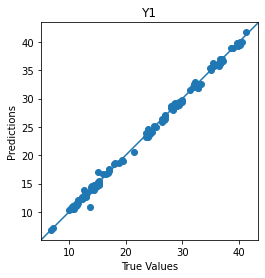

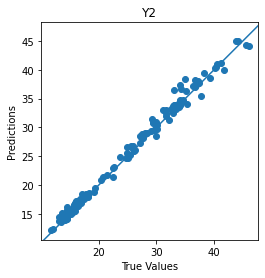

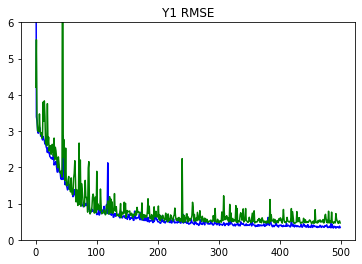

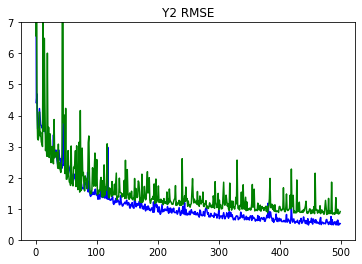

In [10]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)